In [17]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter

In [2]:
plt.style.use('ggplot')
import nltk
nltk.download('stopwords')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from tqdm import tqdm
from tensorflow.keras import backend
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


In [3]:
## ADD STOPWORDS
stop = set(list(stop) + ["http","https", "s", "nt", "m"])

In [5]:
df=pd.read_csv("train.csv")
df[0:10]

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
5   8     NaN      NaN  #RockyFire Update => California Hwy. 20 closed...   
6  10     NaN      NaN  #flood #disaster Heavy rain causes flash flood...   
7  13     NaN      NaN  I'm on top of the hill and I can see a fire in...   
8  14     NaN      NaN  There's an emergency evacuation happening now ...   
9  15     NaN      NaN  I'm afraid that the tornado is coming to our a...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
5       1  
6       1  
7       1  
8       1  
9       1

## data analysis

1.General dataset infos   

    1).Number of samples
    2).Data Columns
    3).Class Label Distributiom
    
2.Text analysis

    1).Number of characters in tweets
    2).Number of words in a tweet
    3).Average word lenght in a tweet
    4).Word distribution
    5).Hashtag Analysis
    6).KW and Location Analysis

### General dataset information¶
Here we show the number of samples, the input data columns and the class label distributiom

In [9]:
print("-Number of samples: {}".format(len(df)))
print("-Input data columns: {}".format(df.columns))
print("-Class label distribution")
print("--Number of positive samples: {}".format(len(df.loc[df['target'] == 1])))
print("--Number of negative samples: {}".format(len(df.loc[df['target'] == 0])))

-Number of samples: 7613
-Input data columns: Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
-Class label distribution
--Number of positive samples: 3271
--Number of negative samples: 4342


--Plot of Y distributions


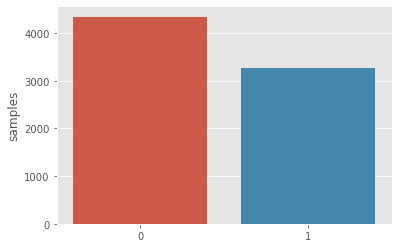

In [10]:
print("--Plot of Y distributions")
x=df.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

def plot_hist_classes(to_plot, _header):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
    df_len = to_plot(1)
    ax1.hist(df_len,color='red')
    ax1.set_title('Negative Tweets [disasters]')
    df_len = to_plot(0)
    ax2.hist(df_len,color='green')
    ax2.set_title('Positive Tweets [good posts]')
    fig.suptitle(_header)
    plt.show()
    plt.close()

### Text analysis
Insights on number of character and words in tweets, word lenght distribution, and word distribution.

-Number of characters in tweets


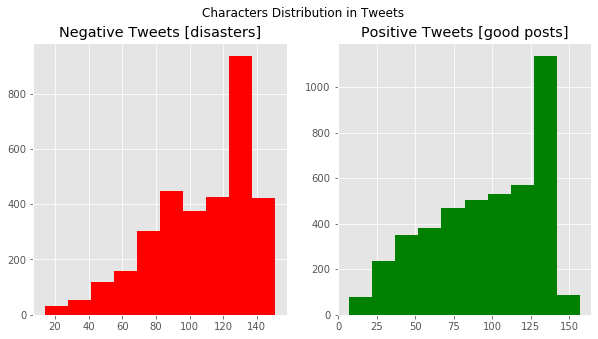

In [11]:
print("-Number of characters in tweets")
def to_plot(_target):
    return df[df['target']==_target]['text'].str.len()

    
plot_hist_classes(to_plot, _header='Characters Distribution in Tweets')

-Number of words in a tweet


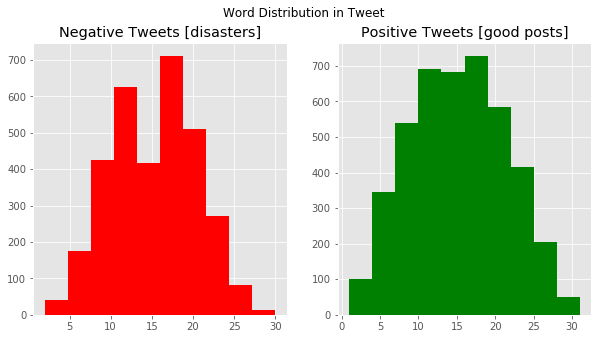

In [14]:
print("-Number of words in a tweet")
def to_plot(_target):
    return df[df['target']==_target]['text'].str.split().map(lambda x: len(x))
def how_to_plot(**kwargs):
    ax1.hist(df_len,**kwargs)
plot_hist_classes(to_plot, _header='Word Distribution in Tweet')

-Average word lenght in a tweet


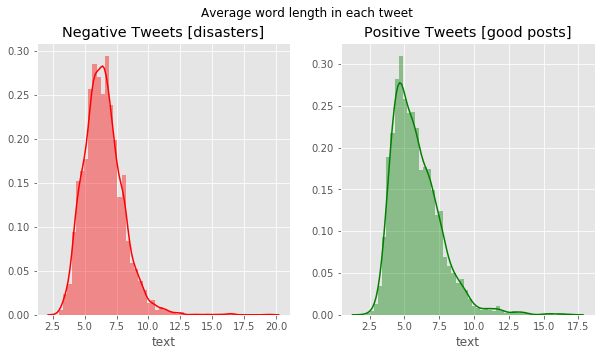

In [15]:
print("-Average word lenght in a tweet")
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Negative Tweets [disasters]')
word=df[df['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Positive Tweets [good posts]')
fig.suptitle('Average word length in each tweet')
plt.show()

-Word distribution
-- Positive Class
      Frequency
Word           
:          3676
#          1703
.          1085
@           905
?           762
...         637
-           397
!           330
'           304
's          276
-- Negative Class
      Frequency
Word           
:          3030
?          2364
.          1882
@          1854
#          1700
!           843
's          515
'           432
...         426
-           388


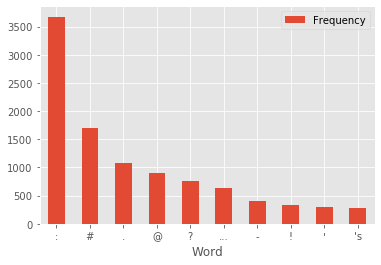

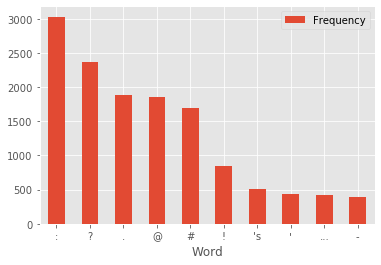

In [19]:
print("-Word distribution")

top_N = 10

print("-- Positive Class")

def show_word_distrib(target=1, field="text"):
    txt = df[df['target']==target][field].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
    words = nltk.tokenize.word_tokenize(txt)
    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stop) 
    
    rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                        columns=['Word', 'Frequency']).set_index('Word')
    print(rslt)
    matplotlib.style.use('ggplot')

    rslt.plot.bar(rot=0)
    
show_word_distrib(target=1, field="text")

print("-- Negative Class")
show_word_distrib(target=0, field="text")

### Hashtag analysis
Small analysis done on the hashtags, to check it's possible discriminator capability for this task.

In [20]:
print("-Hashtag Analysis ")
def find_hashtags(tweet):
    return ", ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or None

def add_hashtags(df):
    from sklearn.feature_extraction.text import CountVectorizer
    
    df['hashtag'] = df["text"].apply(lambda x: find_hashtags(x))
    df['hashtag'].fillna(value="no", inplace=True)
    
    return df

-Hashtag Analysis 


-Number of tweets with hashtags: 7613
-- Hashtag distribution in positive samples 
            Frequency
Word                 
,                 784
news               56
hiroshima          22
earthquake         19
hot                13
prebreak           13
best               13
japan              11
india              10
yyc                10
breaking            9
worldnews           9
world               9
isis                9
sismo               9
abstorm             9
islam               9
disaster            8
wildfire            8
terrorism           8
-- Hashtag distribution in negative samples 
              Frequency
Word                   
,                   803
nowplaying           21
news                 20
hot                  18
prebreak             17
best                 17
gbbo                 14
jobs                 14
islam                14
job                  12
hiring               10
fashion               9
edm                   8
dnb                   8
beyh

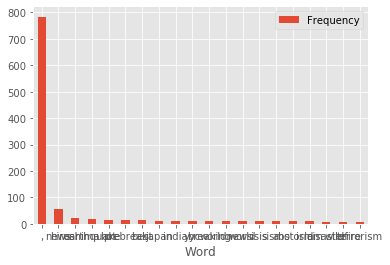

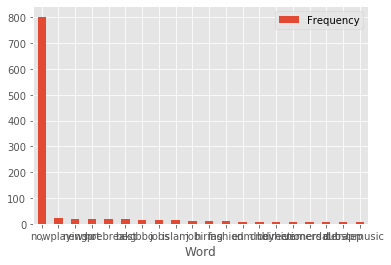

In [21]:
top_N = 20
df = add_hashtags(df)
_l = len([v for v in df.hashtag.values if isinstance(v, str)])
print("-Number of tweets with hashtags: {}".format(_l))
print("-- Hashtag distribution in positive samples ")
show_word_distrib(target=1, field="hashtag")

print("-- Hashtag distribution in negative samples ")
show_word_distrib(target=0, field="hashtag")

There is too much intersection between hashtag in positive and negative samples, meaning that a hashtag approach will not work that well.

### KW and Location analysis

In [22]:
#Remove the encoded space character for keywords, since appears a lot of times and is junk
df['keyword'] = df['keyword'].map(lambda s: s.replace('%20', ' ') if isinstance(s, str) else s)

un_KW  = {kw for kw in df['keyword' ].values if isinstance(kw, str)}
tot_KW = len(df) - len(df[df["keyword" ].isna()])

un_LOC = {lc for lc in df['location'].values if isinstance(lc, str)}
tot_LOC =  len(df) - len(df[df["location"].isna()])

print("Unique KW: {}".format(len(un_KW)))
print("Out of: {}".format(tot_KW))
print("Samples with no KW: {}".format(len(df[df['keyword'].isna()])))


print("Unique LOC: {}".format(len(un_LOC)))
print("Out of: {}".format(tot_LOC))
print("Samples with no Loc: {}".format(len(df[df['location'].isna()])))

Unique KW: 221
Out of: 7552
Samples with no KW: 61
Unique LOC: 3341
Out of: 5080
Samples with no Loc: 2533


LOCATION IS TOO SPARSE TO BE USED.

In [23]:
disaster_keywords = [kw for kw in df.loc[df.target == 1].keyword]
regular_keywords = [kw for kw in df.loc[df.target == 0].keyword]

disaster_keywords_counts = dict(pd.DataFrame(data={'x': disaster_keywords}).x.value_counts())
regular_keywords_counts = dict(pd.DataFrame(data={'x': regular_keywords}).x.value_counts())

all_keywords_counts =  dict(pd.DataFrame(data={'x': df.keyword.values}).x.value_counts())

# we sort the keywords so the most frequents are on top and we print them with relative
# occurrences in both classes of tweets:

for keyword, _ in sorted(all_keywords_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    print("> KW: {}".format(keyword))
    print("-- # in negative tweets: {}".format(disaster_keywords_counts.get(keyword, 0)))
    print("-- # in positive tweets: {}".format(regular_keywords_counts.get(keyword, 0)))
    print('--------')

> KW: fatalities
-- # in negative tweets: 26
-- # in positive tweets: 19
--------
> KW: deluge
-- # in negative tweets: 6
-- # in positive tweets: 36
--------
> KW: armageddon
-- # in negative tweets: 5
-- # in positive tweets: 37
--------
> KW: sinking
-- # in negative tweets: 8
-- # in positive tweets: 33
--------
> KW: damage
-- # in negative tweets: 19
-- # in positive tweets: 22
--------
> KW: harm
-- # in negative tweets: 4
-- # in positive tweets: 37
--------
> KW: body bags
-- # in negative tweets: 1
-- # in positive tweets: 40
--------
> KW: windstorm
-- # in negative tweets: 16
-- # in positive tweets: 24
--------
> KW: siren
-- # in negative tweets: 5
-- # in positive tweets: 35
--------
> KW: evacuate
-- # in negative tweets: 25
-- # in positive tweets: 15
--------


Many KWs in negative tweets are also present in positive ones, meaning that a KW approach is most likely to not work

The same result was given by the hashtag analysis.

## Data Cleaning
Here we are gonna clean the DF. Specifically, we clean:

stopwords (Kept cause removing them cause drop of performances)

URL

HTML

emoji

punctuation

-- Word distrig Positive Class
            Frequency
Word                 
fire              178
news              136
via               121
disaster          117
california        111
suicide           110
police            107
amp               106
people            105
killed             93
like               92
hiroshima          86
storm              85
crash              84
fires              84
us                 81
families           81
train              79
emergency          76
buildings          75
-- Word distrib Negative Class
        Frequency
Word             
like          253
im            243
amp           192
new           168
get           163
dont          141
one           128
body          112
via            99
would          97
video          96
got            91
people         91
love           89
2              86
know           85
back           84
time           83
us             83
see            82


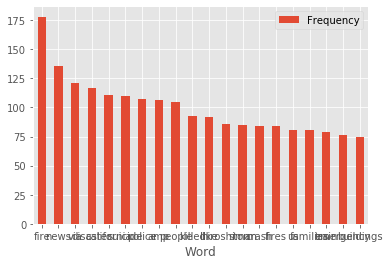

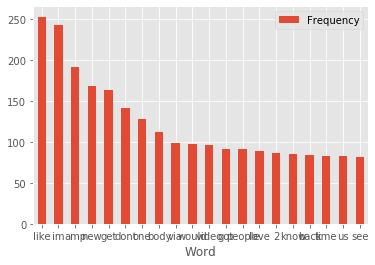

In [26]:
def clean_df(df):
    def remove_stopwords(text):
        if text is not None:
            tokens = [x for x in word_tokenize(text) if x not in stop]
            return " ".join(tokens)
        else:
            return None
        #TMP: TRY TO USE DEFAULT STRING FOR NONE. TODO: USE ROW["KEYWORDS"]
        #df['hashtag'] =df['hashtag'].apply(lambda x : "NO" if x is None else x)
    
    df["text"] = df['text'].apply(lambda x : x.lower())
    #df["hashtag"] = df['hashtag'].apply(lambda x : x.lower())
    
    #df['text'] =df['text'].apply(lambda x : remove_stopwords(x))
    #df['hashtag'] =df['hashtag'].apply(lambda x : remove_stopwords(x))
    
    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)
    
    df['text']=df['text'].apply(lambda x : remove_URL(x))
    def remove_html(text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)

    df['text']=df['text'].apply(lambda x : remove_html(x))
    # Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    
    df['text']=df['text'].apply(lambda x: remove_emoji(x))
    def remove_punct(text):
        table=str.maketrans('','',string.punctuation)
        return text.translate(table)

    df['text']=df['text'].apply(lambda x : remove_punct(x))
    
    df.text = df.text.replace('\s+', ' ', regex=True)
    return df

df = clean_df(df)
print("-- Word distrig Positive Class")

show_word_distrib(target=1, field="text")

print("-- Word distrib Negative Class")
show_word_distrib(target=0, field="text")

## Utils for models

In [27]:
def read_test(test_path="test.csv"):
    
    my_df = pd.read_csv(test_path)
    
    res_df = my_df[['id']]
    my_df = my_df[['text']]
    
    add_hashtags(my_df)
    my_df = clean_df(my_df)
    print("Test DF: {}".format(my_df.head(10)))
    
    return my_df, res_df

def dump_preds(res_df, preds, out="default"):
    res_df['target'] = None
    
    for i, p in  enumerate(preds):
        res_df.ix[i, 'target'] = p
    
    res_df.to_csv(out, index = False)
    
def split_data(df, _t=True):
    X = df.text
    if _t:
        Y = df.target
        le = LabelEncoder()
        Y = le.fit_transform(Y)
        Y = Y.reshape(-1,1)
        return X, Y
    else:
        return X

### Baseline Models
We build a simple majority model and TFIDF + LogReg to check the problem hardness.

In [28]:
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

'\nBuild a baseline TFIDF + LOGREG based just on text\n'

In [29]:
"""
Build a baseline TFIDF + LOGREG based just on text
"""
def build_tfidf_logreg(df):
    my_df = df[['text','target']]
    x_features = my_df.columns[0]
    x_data = my_df[x_features]
    Y = my_df["target"]

    x_train, x_validation, y_train, y_validation = model_selection.train_test_split(
        x_data.values, Y.values, test_size=0.2, random_state=7)
    
    # configure TfidfVectorizer to accept tokenized data
    # reference http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/
    tfidf_vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None)

    lr = LogisticRegression()
    tfidf_lr_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('lr', lr)])
    tfidf_lr_pipe.fit(x_train, y_train)
    
    return tfidf_lr_pipe

In [30]:
def test_tfidf_logreg(model, test_path="test.csv"):
    
    my_df, res_df = read_test(test_path="test.csv")
    
    #x_features = my_df.columns[0]
    x_data = my_df["text"].values

    preds = model.predict(x_data)
    
    #dump_preds(res_df, preds, out="res_tfidf_logreg4_0.csv")
    
    return res_df

In [33]:
"""
Build a majority model
"""
def test_majority_model(test_path="test.csv"):
    
    my_df = pd.read_csv(test_path)
    
    res = my_df[['id']]
    res['target'] = 1
    
    res.to_csv("res_majority.csv", index = False)
    return res

In [34]:
test_majority_model()

/Users/mac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


id  target
0         0       1
1         2       1
2         3       1
3         9       1
4        11       1
...     ...     ...
3258  10861       1
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       1

[3263 rows x 2 columns]

In [37]:
tfidf_log_reg = build_tfidf_logreg(df)
test_tfidf_logreg(tfidf_log_reg, test_path="test.csv")

Test DF:                                                 text             hashtag
0                 just happened a terrible car crash                  no
1  heard about earthquake is different cities sta...          earthquake
2  there is a forest fire at spot pond geese are ...                  no
3              apocalypse lighting spokane wildfires  Spokane, wildfires
4      typhoon soudelor kills 28 in china and taiwan                  no
5                      were shakingits an earthquake                  no
6  theyd probably still show more life than arsen...                  no
7                                    hey how are you                  no
8                                    what a nice hat                  no
9                                           fuck off                  no


/Users/mac/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


id
0         0
1         2
2         3
3         9
4        11
...     ...
3258  10861
3259  10865
3260  10868
3261  10874
3262  10875

[3263 rows x 1 columns]

## Test RNN Model
Here we test a simple LSTM model with Dropout. The experiment does not give better performances w.r.t gradient boosting.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

#Value tuned based on data analysis
max_words = 750
max_len = 160

def process_data(X, tok=None):
    if tok is None:
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(X)
    sequences = tok.texts_to_sequences(X)
    sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
    return sequences_matrix, tok

def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [39]:
def test_model(model, tok=None, test_path="test.csv", cut=0.5):
    
    my_df, res = read_test(test_path="test.csv")
    
    X = split_data(my_df, _t=False)
    sequences_matrix, tok = process_data(X, tok=tok)
    preds = model.predict(sequences_matrix)

    normalized_preds = []
    for p in preds:
        if p >= cut:
            normalized_preds.append(1)
            
        else:
            normalized_preds.append(0)
    #dump_preds(res, normalized_preds, out="res_rnn.csv")
    return res

In [40]:
def tune_cutoff(model, tok):
    
    x_tune = df['text'].values
    x_target = df[['target']]
    
    
    X, Y = split_data(df)
    sequences_matrix, tok = process_data(X, tok=tok)
    preds = model.predict(sequences_matrix)
    
    x_target["preds"] = preds
    
    accumulator = 0
    _0 = []
    max_0 = 0
    _1 = []
    min_1 = 0
    
    for i, row in x_target.iterrows():
        if row['target'] == 0:
            _0.append(row['preds'])
            if row['preds'] > max_0:
                max_0 = row['preds']
        else:
            _1.append(row['preds'])
            if row['preds'] < min_1:
                min_1 = row['preds']

    mean_0 = sum(_0)/len(_0)
    mean_1 = sum(_1)/len(_1)
    return max(mean_0, mean_1)/min(mean_0, mean_1)

In [41]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
X, Y = split_data(df)
sequences_matrix, tok = process_data(X, tok=None)

model.fit(sequences_matrix,Y,batch_size=128,epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.001)])

    
cut = tune_cutoff(model, tok)

test_model(model, tok=tok, cut=cut)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 160)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 160, 50)           37500     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

/Users/mac/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 7s 1ms/step - loss: 0.6142 - accuracy: 0.6637 - val_loss: 0.5161 - val_accuracy: 0.7610
Epoch 2/10
6090/6090 [==============================] - 6s 945us/step - loss: 0.4652 - accuracy: 0.7911 - val_loss: 0.4603 - val_accuracy: 0.7807
Epoch 3/10
6090/6090 [==============================] - 6s 956us/step - loss: 0.4328 - accuracy: 0.8087 - val_loss: 0.4503 - val_accuracy: 0.7951
Epoch 4/10
6090/6090 [==============================] - 6s 980us/step - loss: 0.4180 - accuracy: 0.8215 - val_loss: 0.4506 - val_accuracy: 0.7892


/Users/mac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Test DF:                                                 text             hashtag
0                 just happened a terrible car crash                  no
1  heard about earthquake is different cities sta...          earthquake
2  there is a forest fire at spot pond geese are ...                  no
3              apocalypse lighting spokane wildfires  Spokane, wildfires
4      typhoon soudelor kills 28 in china and taiwan                  no
5                      were shakingits an earthquake                  no
6  theyd probably still show more life than arsen...                  no
7                                    hey how are you                  no
8                                    what a nice hat                  no
9                                           fuck off                  no


id
0         0
1         2
2         3
3         9
4        11
...     ...
3258  10861
3259  10865
3260  10868
3261  10874
3262  10875

[3263 rows x 1 columns]